<a href="https://colab.research.google.com/github/TejasAmle/StyleGAN/blob/main/Copy_of_Copy_of_Animating_Yourself_as_a_Disney_Character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Toonify yourself!

Please ensure that you're using a GPU runtime

First some setup:

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
!git clone https://github.com/justinpinkney/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 269, done.
remote: Total 269 (delta 0), reused 0 (delta 0), pack-reused 269
Receiving objects: 100% (269/269), 2.32 MiB | 13.33 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/stylegan2
CPU says hello.
GPU says hello.


In [3]:
!mkdir raw
!mkdir aligned
!mkdir generated

## Upload your own photos

Upload your photos to `raw/`. These don't need to be aligned as we'll use a face detector to grab all the faces and transform them into the correct format. One note of caution is that you'll need a pretty high-resolution picture of a face to get a sharp result (the final face crop is resized to 1024x1024 pixels)

We'll grab a example image from the internet to work with.

The basic process is:
- Extract faces and align the images
- Project the images (i.e. find the latent code)
- Toonify the images (i.e. use the latent code with the toon model)

Results will be placed in the stylegan2/generated folder

In [ ]:
!wget /content/stylegan2/raw/DSC_7326.JPG -O raw/example.jpg

/content/stylegan2/raw/DSC_7326.JPG: Scheme missing.


In [4]:
import pretrained_networks

# use my copy of the blended model to save Doron's download bandwidth
# get the original here https://mega.nz/folder/OtllzJwa#C947mCCdEfMCRTWnDcs4qw
blended_url = "https://drive.google.com/uc?id=1H73TfV5gQ9ot7slSed_l-lim9X7pMRiU" 
ffhq_url = "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"

_, _, Gs_blended = pretrained_networks.load_networks(blended_url)
_, _, Gs = pretrained_networks.load_networks(ffhq_url)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Compiling... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Compiling... Loading... Done.


In [5]:
!python align_images.py raw aligned

64045056/64040097 [==============================] - 2s 0us/step


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "example_01.png"...


In [8]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-toon.jpg"))


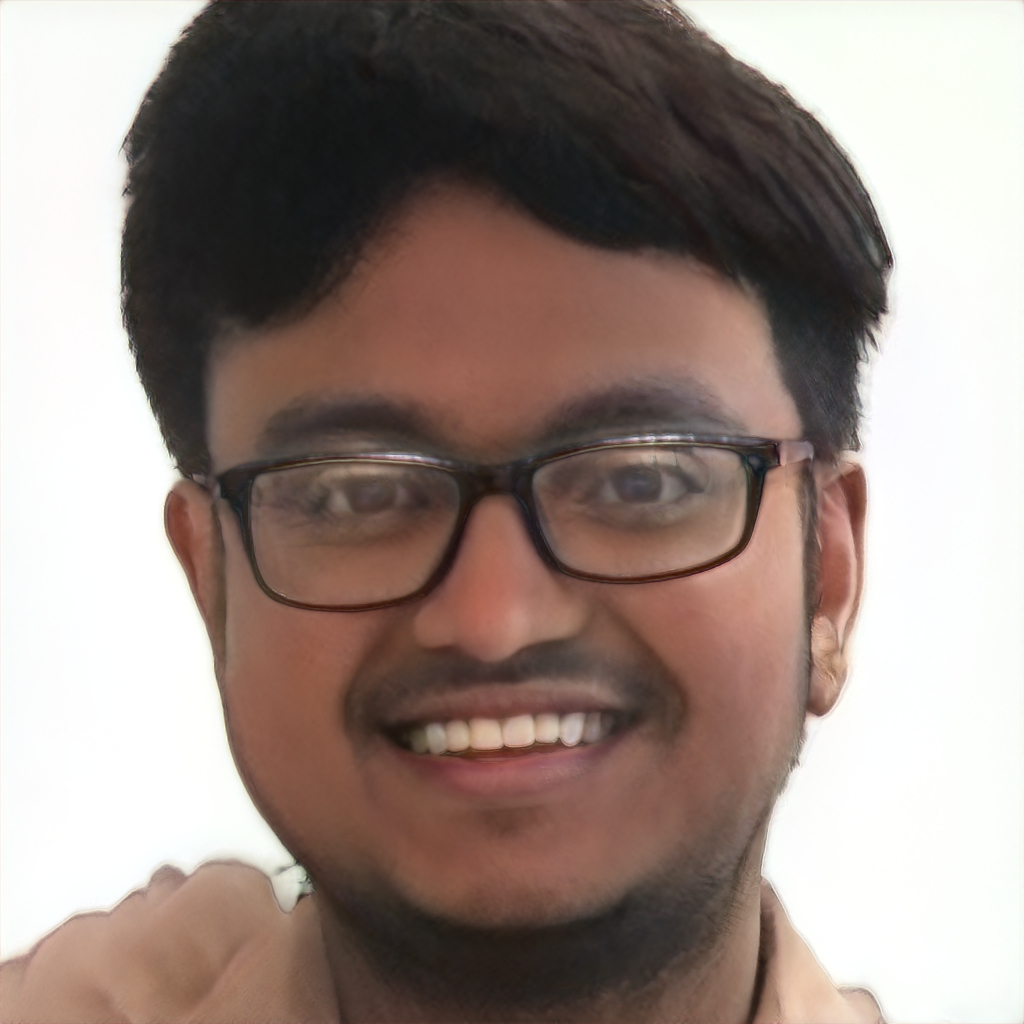

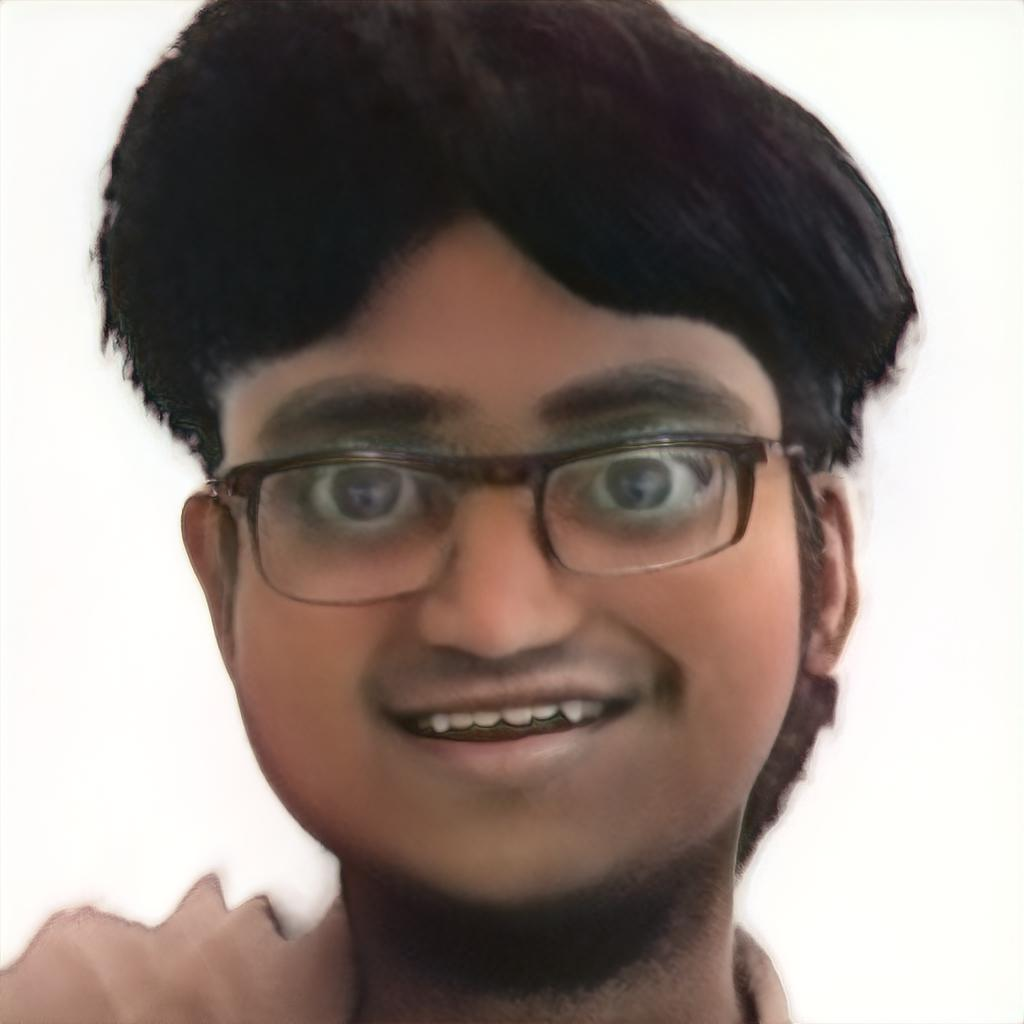

In [9]:
from IPython.display import Image 
embedded = Image(filename="generated/example_01.png", width=256)
display(embedded)
tooned = Image(filename="generated/example_01-toon.jpg", width=256)
display(tooned)

# Animating
Next, we will animate the image using Aliaksanr first order motion model

In [10]:
!git clone https://github.com/AliaksandrSiarohin/first-order-model

Cloning into 'first-order-model'...
remote: Enumerating objects: 249, done.
remote: Total 249 (delta 0), reused 0 (delta 0), pack-reused 249
Receiving objects: 100% (249/249), 72.12 MiB | 35.49 MiB/s, done.
Resolving deltas: 100% (123/123), done.


Set up a path, so we do not need to change directory

In [11]:
try: # set up path
    import sys
    sys.path.append('/content/stylegan2/first-order-model')
    print('Path added')
except Exception as e:
    print(e)
    pass

Path added


Now, we will download the pretrained weights for the keypoint detector and video generator. The file is around ~600 MB and may take a while to download. if wget download failed you can manually download and move it to your Colab.

In [17]:
!wget "https://drive.google.com/uc?export=download&id=1jmcn19-c3p8mf39aYNXUhdMqzqDYZhQ_" -O vox-cpk.pth.tar

--2020-11-08 14:00:01--  https://drive.google.com/uc?export=download&id=1jmcn19-c3p8mf39aYNXUhdMqzqDYZhQ_
Resolving drive.google.com (drive.google.com)... 173.194.194.139, 173.194.194.113, 173.194.194.100, ...
Connecting to drive.google.com (drive.google.com)|173.194.194.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘vox-cpk.pth.tar’

vox-cpk.pth.tar         [ <=>                ]   3.17K  --.-KB/s    in 0s      

2020-11-08 14:00:01 (28.8 MB/s) - ‘vox-cpk.pth.tar’ saved [3251]



Load the model

In [20]:
from demo import load_checkpoints
generator, kp_detector = load_checkpoints(config_path='first-order-model/config/vox-256.yaml', 
                            checkpoint_path='/content/drive/My Drive/test/vox-cpk.pth.tar')

Download source video, you can use your own or use the example video

In [21]:
!wget https://drive.google.com/uc?id=1LjDoFmeP0hZQSsUmnou0UbQJJzQ8rMLR -O src_video.mp4

# Some other videos
# https://drive.google.com/uc?id=19F7ambg3osMEBapOZayZ07RaDI_ij9OS
# https://drive.google.com/uc?id=1LjDoFmeP0hZQSsUmnou0UbQJJzQ8rMLR
# https://drive.google.com/uc?id=1d1JUp3SrQlB-S11oHdRXNLzlVaTgG5bZ


--2020-11-08 14:06:01--  https://drive.google.com/uc?id=1LjDoFmeP0hZQSsUmnou0UbQJJzQ8rMLR
Resolving drive.google.com (drive.google.com)... 209.85.234.102, 209.85.234.101, 209.85.234.113, ...
Connecting to drive.google.com (drive.google.com)|209.85.234.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6mcfi6j0nj2iisddr6grpu2mau1srop0/1604844300000/06117322118322238542/*/1LjDoFmeP0hZQSsUmnou0UbQJJzQ8rMLR [following]
--2020-11-08 14:06:02--  https://doc-0c-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6mcfi6j0nj2iisddr6grpu2mau1srop0/1604844300000/06117322118322238542/*/1LjDoFmeP0hZQSsUmnou0UbQJJzQ8rMLR
Resolving doc-0c-c0-docs.googleusercontent.com (doc-0c-c0-docs.googleusercontent.com)... 74.125.126.132, 2607:f8b0:4001:c1d::84
Connecting to doc-0c-c0-docs.googleusercontent.com (doc-0c-c0-docs.googleusercontent.com)|74.125

Generate animation

In [22]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

from demo import make_animation
from skimage import img_as_ubyte

import warnings
warnings.filterwarnings("ignore")

source_image = imageio.imread('generated/example_01-toon.jpg')
reader = imageio.get_reader('src_video.mp4')


#Resize image and video to 256x256

source_image = resize(source_image, (256, 256))[..., :3]

fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]

# Generate animation
predictions = make_animation(source_image, driving_video, generator, kp_detector, relative=True)

def display(source, driving, generated=None):
    fig = plt.figure(figsize=(8 + 4 * (generated is not None), 6))

    ims = []
    for i in range(len(driving)):
        cols = [source]
        cols.append(driving[i])
        if generated is not None:
            cols.append(generated[i])
        im = plt.imshow(np.concatenate(cols, axis=1), animated=True)
        plt.axis('off')
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=1000)
    plt.close()
    return ani
    

HTML(display(source_image, driving_video, predictions).to_html5_video())

100%|██████████| 150/150 [00:06<00:00, 22.87it/s]


In [2]:
!git push StyleGAN


fatal: not a git repository (or any of the parent directories): .git
